In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.figure_1 import plot_figure_1
from jtb_2022_code import FigureSingleCellData

In [3]:
## LOAD AND PROCESS UMAP FOR UMAP PANELS ###
data = FigureSingleCellData()
data.do_projections()

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


Loading Bulk Data from /home/cj59/Documents/R/rapa_20210628/data/20210312_RAPA_BULK_TIMECOURSE.tsv.gz
Running DESeq2
Processing Results
Clustering Results


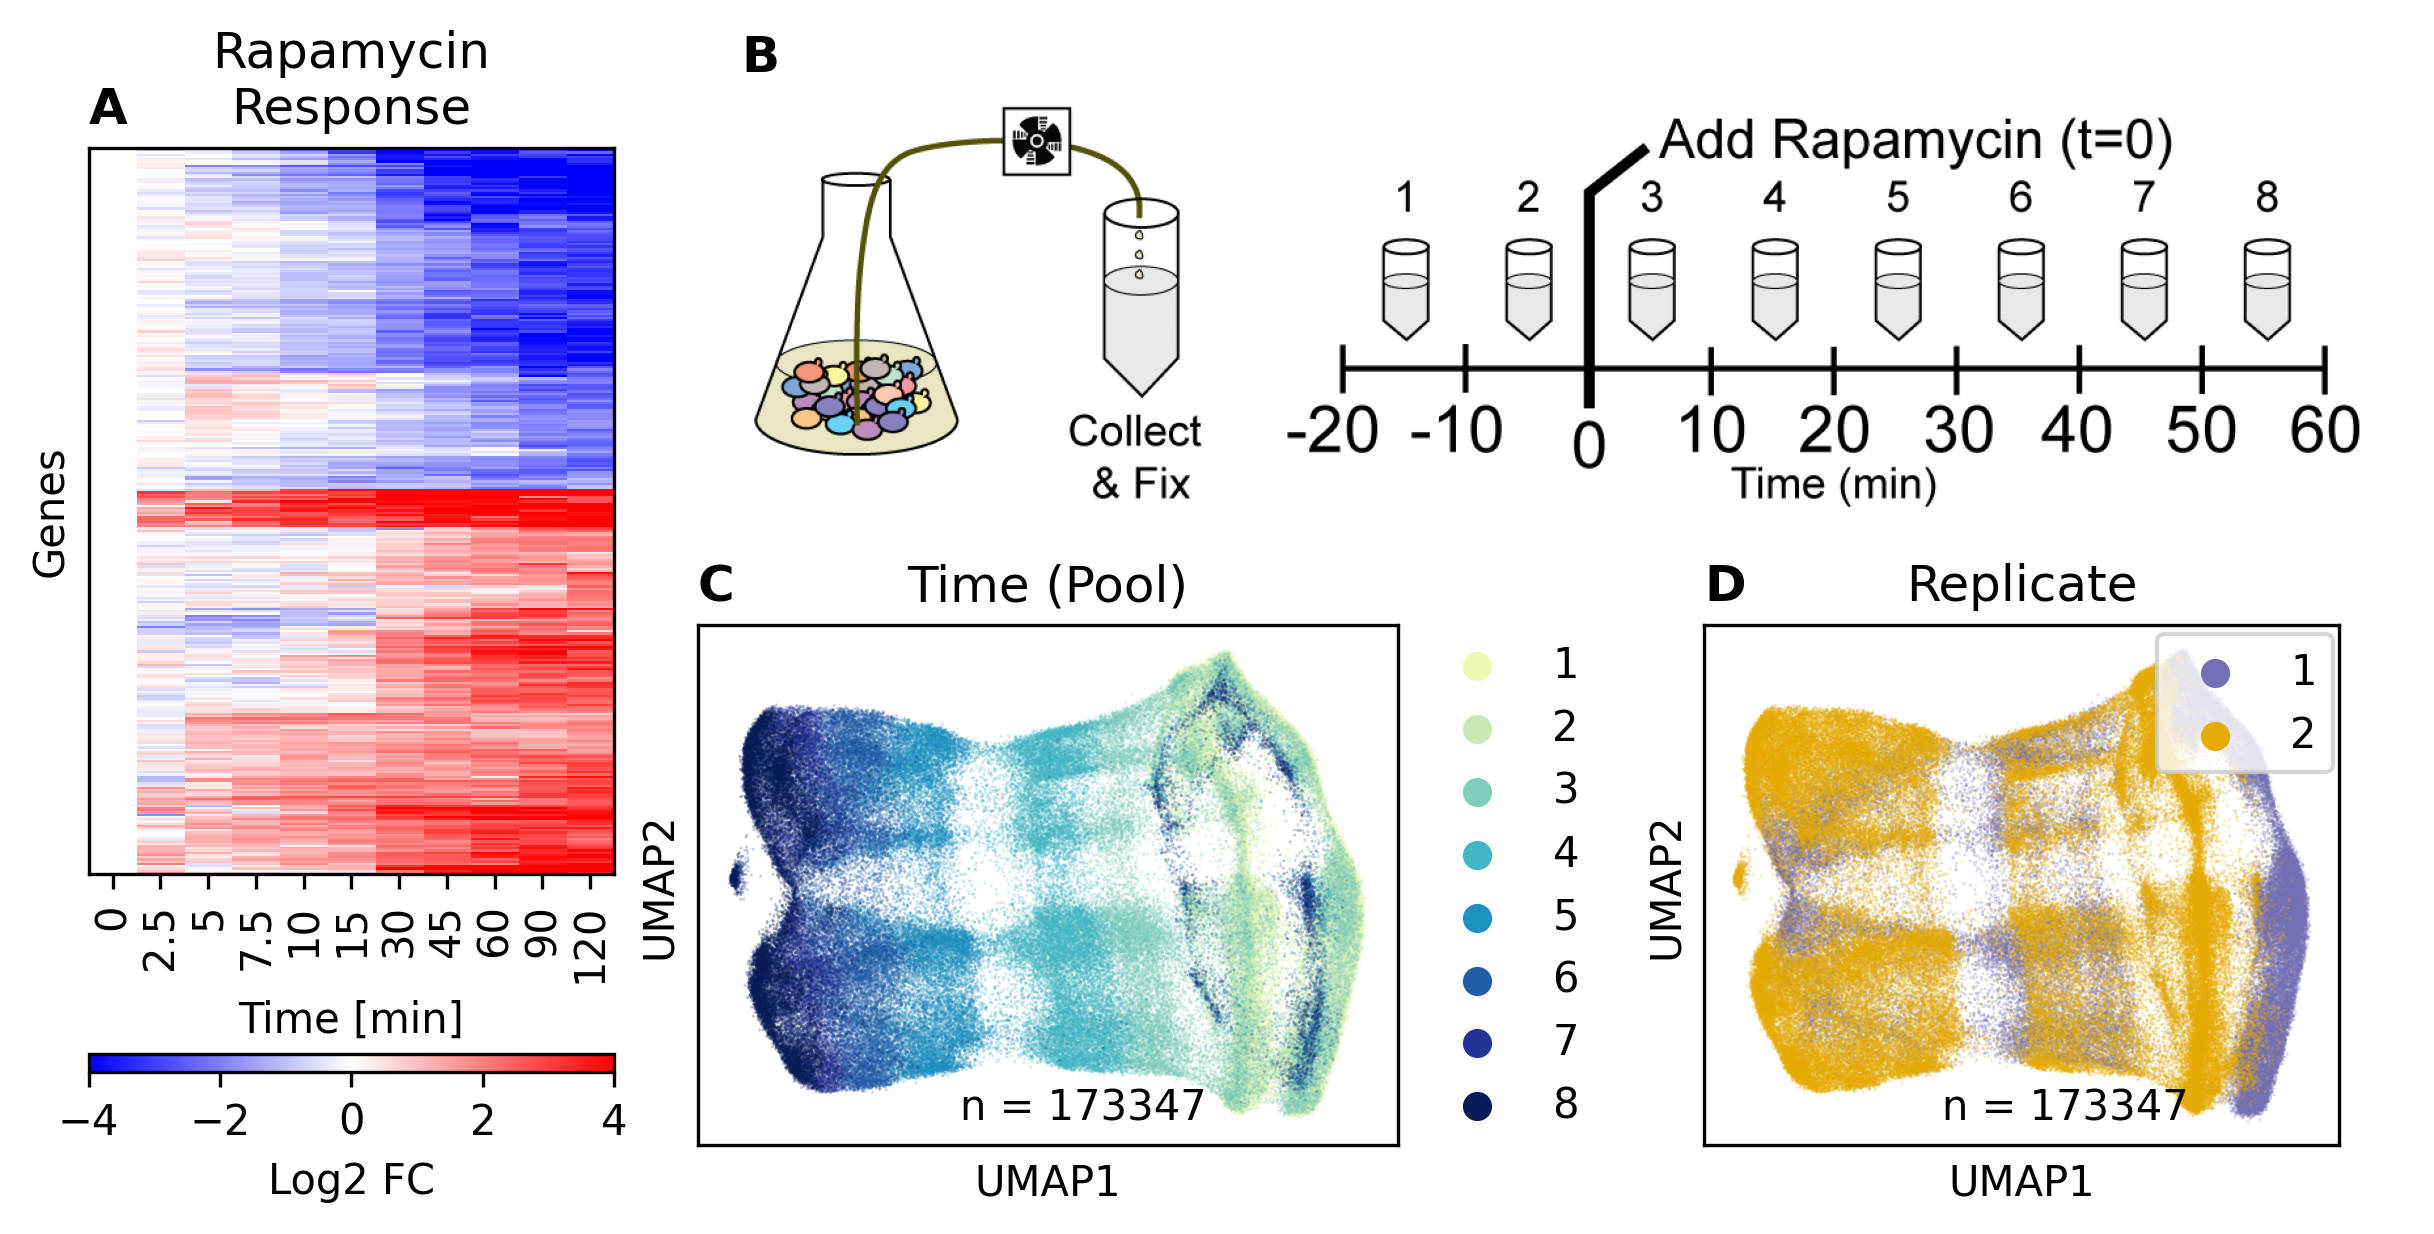

In [4]:
fig = plot_figure_1(data)

In [ ]:
import numpy as np
import scanpy as sc

from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.figure_constants import *
from jtb_2022_code.utils.figure_data import load_rapa_bulk_data, rapa_bulk_times
from jtb_2022_code.utils.Figure_deseq import DESeq2, hclust

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

panel_labels = {'hm': "A",
                'image': "B",
                'umap_1': "C",
                'umap_2': "D"}

panel_titles = {'hm': "Rapamycin\nResponse",
                'image': "",
                'umap_1': "Time",
                'umap_2': "Expt. Replicate"}


## LOAD AND PROCESS BULK RAPAMYCIN DATA FOR HEATMAP PANEL ###
rapa_bulk, rapa_bulk_meta = load_rapa_bulk_data()

print("Running DESeq2")
de_obj = DESeq2(rapa_bulk, rapa_bulk_meta, "~Time", threads=4).run(fitType = "local", quiet=True)

print("Processing Results")
res = de_obj.multiresults(lambda y: ("Time", y, "0.0"), rapa_bulk_times(), "Time", lfcThreshold=FIGURE_1A_LFC_THRESHOLD)
plot_genes = res.loc[res['padj'] < FIGURE_1A_PADJ_THRESHOLD, :].index.unique()
plot_genes = res.loc[res.index.isin(plot_genes), :].pivot(columns="Time", values="log2FoldChange").reindex(rapa_bulk_times(include_0=True), axis=1).fillna(0)

print("Clustering Results")
plot_hclust = hclust(plot_genes)
plot_y_order = plot_hclust['labels'][plot_hclust['order'] - 1]
plot_genes = plot_genes.reindex(plot_y_order, axis=0)

In [ ]:
plot_x_labels = list(map(str, map(int, map(float, rapa_bulk_times(include_0=True)))))
plot_x_labels[1] = '2.5'
plot_x_labels[3] = '7.5'

### PANEL A - IMSHOW HEATMAP ###

fig_refs = {}

fig, axd = plt.subplot_mosaic([['hm', 'image', 'image'],
                               ['hm', 'umap_1', 'umap_2']],
                              gridspec_kw=dict(width_ratios=[0.75, 1, 1], 
                                               height_ratios=[1, 1.25],
                                               hspace=0), 
                              figsize=(8, 4), dpi=300, 
                              constrained_layout=True)

### PANEL A - IMSHOW HEATMAP ###
fig_refs['hm_im'] = axd['hm'].imshow(squeeze_data(plot_genes, FIGURE_1A_MINMAX), 
                                     cmap='bwr', aspect='auto', interpolation='nearest')

fig_refs['hm_divider'] = make_axes_locatable(axd['hm'])
fig_refs['hm_toppad'] = fig_refs['hm_divider'].append_axes('top', size='3%', pad=0.1)
fig_refs['hm_cax'] = fig_refs['hm_divider'].append_axes('bottom', size='2.5%', pad=0.6)
fig_refs['hm_bottompad'] = fig_refs['hm_divider'].append_axes('bottom', size='6%', pad=0.1)
fig_refs['hm_toppad'].axis('off')
fig_refs['hm_bottompad'].axis('off')

axd['hm'].set_xticks(np.arange(len(plot_x_labels)), labels=plot_x_labels, rotation=90, ha="center")
axd['hm'].set_yticks([], labels=[])
axd['hm'].set_ylabel("Genes")
axd['hm'].set_xlabel("Time [min]")
axd['hm'].set_title("Rapamycin Response")

fig_refs['hm_cbar'] = axd['hm'].figure.colorbar(fig_refs['hm_im'], cax=fig_refs['hm_cax'], orientation="horizontal", fraction=1.0)
fig_refs['hm_cbar'].set_label("Log2 FC")

### PANEL B - IMSHOW SCHEMATIC ###
axd['image'].imshow(plt.imread(FIG1B_FILE_NAME), aspect='equal')
axd['image'].axis('off')

### PANEL C - SCANPY UMAP ###
fig_refs['umap_1'] = sc.pl.umap(data.all_data, ax=axd['umap_1'], color="Pool", palette=pool_palette(), show=False, alpha=0.25, size=2)
fig_refs['umap_2'] = sc.pl.umap(data.all_data, ax=axd['umap_2'], color="Experiment", palette=expt_palette(), show=False, alpha=0.25, size=2, legend_loc='none')
add_legend_in_plot(add_legend_axis(axd['umap_2']), expt_palette(), data.all_data.obs['Experiment'].dtype.categories.values)


for aid in ['umap_1', 'umap_2']:
    axd[aid].annotate(f"n = {data.all_data.shape[0]}", xy=(5, 0.2),  xycoords='data', xytext=(0.4, 0.05), textcoords='axes fraction')

for ax_id, label in panel_labels.items():
    axd[ax_id].set_title(panel_titles[ax_id])
    axd[ax_id].set_title(label, loc='left', weight='bold')

#fig.tight_layout()    
